In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from data import load_database_train
from preprocessing import InterpolateRawData
from train import grid_search, scikit_train_validate
from sklearn.model_selection import cross_val_score
from cross_validation import cv_folds_author
import numpy as np
from plotter import plot_all_readings


%matplotlib inline

In [2]:
database_train = load_database_train()
X_processed = InterpolateRawData(num_samples=40).fit_transform(database_train.X)

# Modelo Base

## Analisando quantidade de amostragem na interpolação dos dados 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   11.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   25.2s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   32.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   46.7s
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed:  1.0min remaining:    1.5s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:  1.0min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'interpolate__num_samples': 5},0.94,0.03,0.65,0.15
1,{'interpolate__num_samples': 10},1.00,0.00,0.66,0.12
2,{'interpolate__num_samples': 20},1.00,0.00,0.68,0.13
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14
4,{'interpolate__num_samples': 80},1.00,0.00,0.70,0.15
5,{'interpolate__num_samples': 120},1.00,0.00,0.70,0.15
6,{'interpolate__num_samples': 240},1.00,0.00,0.70,0.14
7,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 10}",1.00,0.00,0.49,0.20
8,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 50}",1.00,0.00,0.48,0.20
9,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 100}",1.00,0.00,0.46,0.19


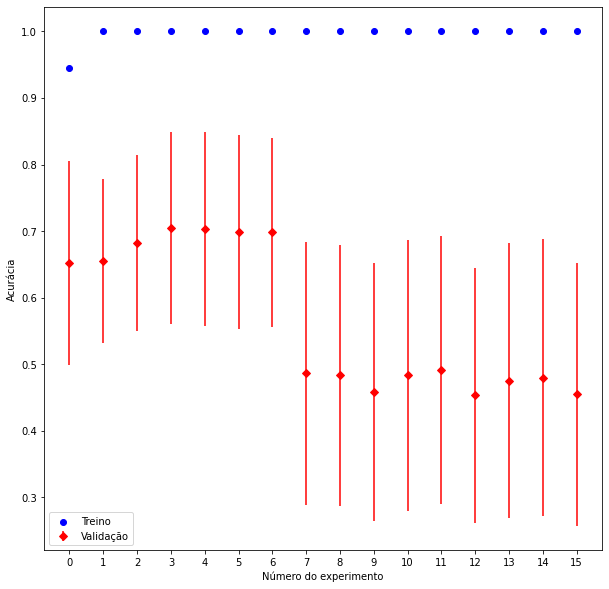

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14


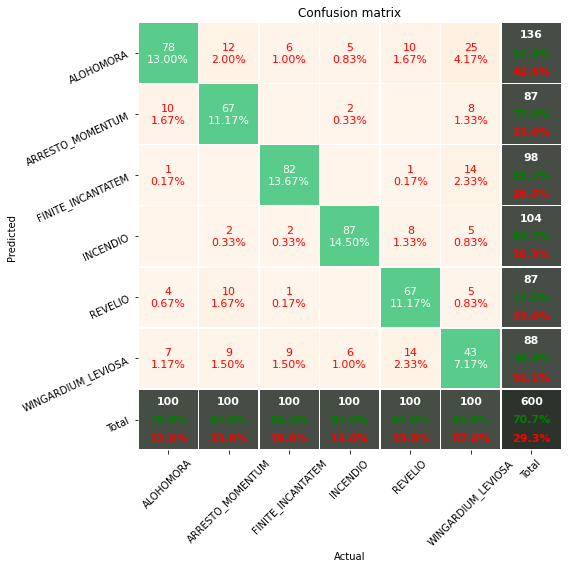

Pipeline(steps=[('interpolate', InterpolateRawData(num_samples=40)),
                ('logistic',
                 LogisticRegression(max_iter=100000, random_state=0))])

In [3]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = [
    {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]},
    
    {'interpolate__num_samples': [None], 
     'interpolate__timestep': [10, 50, 100], 
     'interpolate__max_time': [6000, 5000, 4000] 
    }
]

grid_search(pipe, parameters, database_train.X, database_train.y, database_train.cv_author, n_jobs=6)

Segundo modelo base de **Regressão Logistica**, amostragens com timestep fixo (*'interpolate__num_samples': None*)  foram bem inferiores em realção ao tamanho variavel. Observa-se uma melhoria aumentando o *num_samples* até *num_samples = 40*  que trouxe bons resultados, e maiores amostragens não trouxeram mudanças significativas. 

Nosso método grid_search já faz o **validação cruzada** considerando como **divisão de dados os autores** (*cv_folds_author*). Olhando os scores abaixo, percebemos como houve muita variação entre os folds, visto que cada fold é um autor com celular diferente que não tem no modelo.

In [4]:
pipe = Pipeline([
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, X_processed, database_train.y, cv=database_train.cv_author))

[0.875      0.5        0.58333333 0.80833333 0.76666667]


Se não usassemos este método, e os dados fossem misturado, o resultado do modelo seria muito enviesado como abaixo, onde manteve uma boa acurácia acima dos 84% em todos os folds

In [5]:
print(cross_val_score(pipe, X_processed, database_train.y, cv=5))

[0.91666667 0.9        0.84166667 0.90833333 0.89166667]


# Redes Neurais

### Encontrando melhor learning rate

Utilizando uma rede totalmente conectada para classificação (**softmax na ultima camada**), com **100 neuronios na primeira camada** escondida e **10 na segunda camada**, com função de ativação **relu** (padrões do scikit), vamos verificar o funcionamento variando a **taxa de apredizado inicial** do método **Adam**:

dict_keys(['memory', 'steps', 'verbose', 'mlp', 'mlp__activation', 'mlp__alpha', 'mlp__batch_size', 'mlp__beta_1', 'mlp__beta_2', 'mlp__early_stopping', 'mlp__epsilon', 'mlp__hidden_layer_sizes', 'mlp__learning_rate', 'mlp__learning_rate_init', 'mlp__max_fun', 'mlp__max_iter', 'mlp__momentum', 'mlp__n_iter_no_change', 'mlp__nesterovs_momentum', 'mlp__power_t', 'mlp__random_state', 'mlp__shuffle', 'mlp__solver', 'mlp__tol', 'mlp__validation_fraction', 'mlp__verbose', 'mlp__warm_start'])
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   10.9s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done  28 out of  35 | elapsed:   12.6s remaining:    3.1s
[Parallel(n_jobs=6)]: Done  32 out of  35 | elapsed:   12.7s remaining:    1.2s
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   12.8s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__learning_rate_init': 0.0001},1.00,0.00,0.74,0.15
1,{'mlp__learning_rate_init': 0.0005},1.00,0.00,0.84,0.18
2,{'mlp__learning_rate_init': 0.001},1.00,0.00,0.80,0.20
3,{'mlp__learning_rate_init': 0.005},0.99,0.01,0.76,0.15
4,{'mlp__learning_rate_init': 0.01},0.77,0.14,0.58,0.17
5,{'mlp__learning_rate_init': 0.05},0.17,0.01,0.17,0.01
6,{'mlp__learning_rate_init': 0.1},0.17,0.01,0.17,0.01


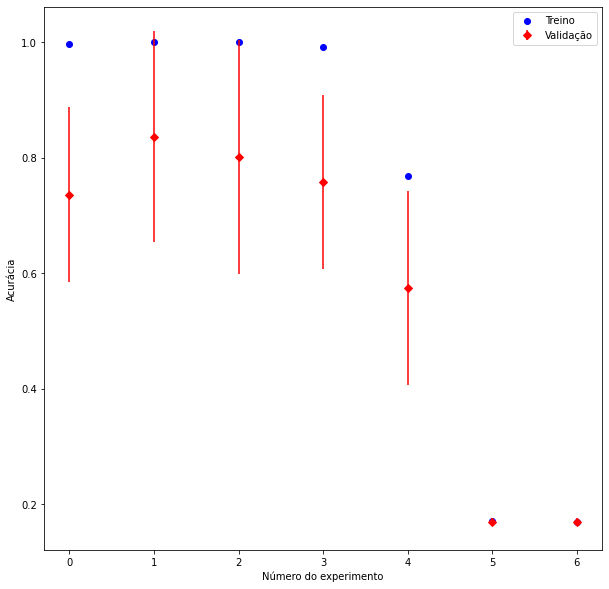

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
1,{'mlp__learning_rate_init': 0.0005},1.00,0.00,0.84,0.18


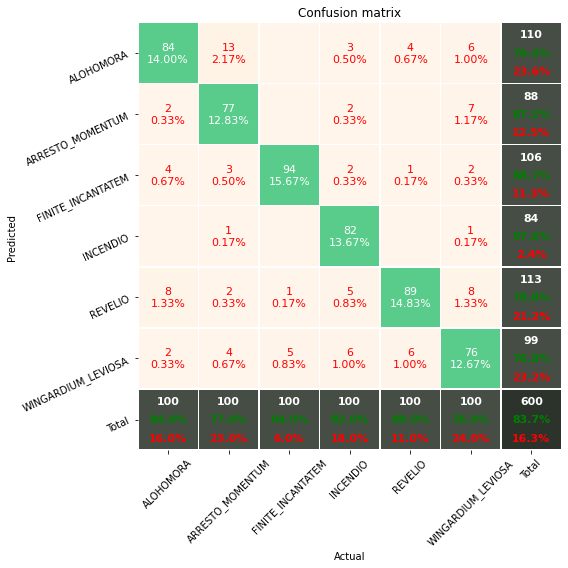

Pipeline(steps=[('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 10),
                               learning_rate_init=0.0005, max_iter=100000,
                               random_state=0))])

In [6]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, hidden_layer_sizes=(100, 10)))
])

print(pipe.get_params().keys())

parameters = {'mlp__learning_rate_init': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vemos que existe uma tendencia do learning rate baixo possuir resultados melhores. Leraning rates muito altos leveram a não Um *learning_rate = 0.0005* parece muito satisfatório para convergencia da rede.

### Testando diferentes funções de ativação

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:    7.2s remaining:    4.8s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:    9.2s remaining:    3.1s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:   11.9s remaining:    1.3s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   12.7s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__activation': 'identity'},1.00,0.00,0.74,0.18
1,{'mlp__activation': 'logistic'},1.00,0.00,0.74,0.19
2,{'mlp__activation': 'tanh'},1.00,0.00,0.77,0.15
3,{'mlp__activation': 'relu'},1.00,0.00,0.84,0.18


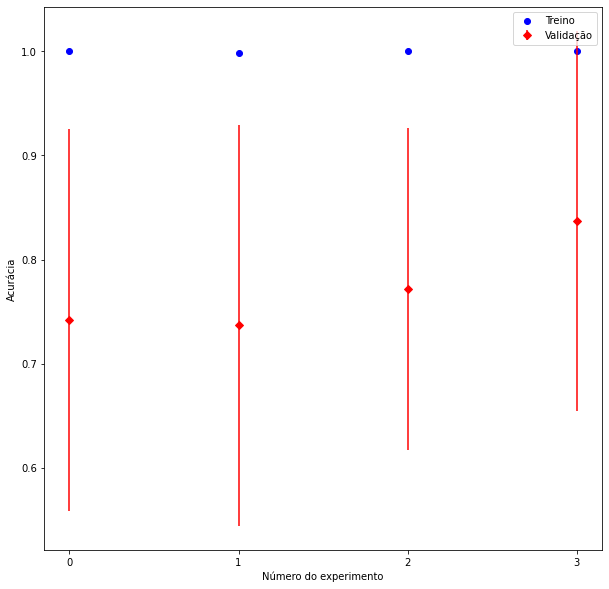

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'mlp__activation': 'relu'},1.00,0.00,0.84,0.18


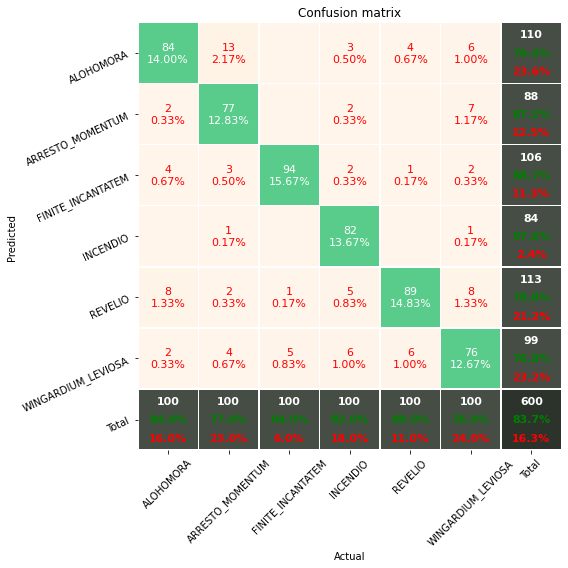

Pipeline(steps=[('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 10),
                               learning_rate_init=0.0005, max_iter=100000,
                               random_state=0))])

In [9]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000,
                          hidden_layer_sizes=(100, 10), learning_rate_init=0.0005))
])

parameters = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu']}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Não conseguimos notar diferenças significaticas na função de ativação, a **relu** parece ser levemente melhor, vamos adota-la como padrão para os proximos experimentos

### Testando diferentes batch-size

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   21.5s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   29.4s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   36.6s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   53.3s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  95 out of  95 | elapsed:  1.3min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__batch_size': 10},1.00,0.00,0.78,0.20
1,{'mlp__batch_size': 20},1.00,0.00,0.80,0.18
2,{'mlp__batch_size': 30},1.00,0.00,0.81,0.16
3,{'mlp__batch_size': 40},1.00,0.00,0.82,0.17
4,{'mlp__batch_size': 50},1.00,0.00,0.82,0.19
5,{'mlp__batch_size': 60},1.00,0.00,0.82,0.19
6,{'mlp__batch_size': 70},1.00,0.00,0.83,0.18
7,{'mlp__batch_size': 80},1.00,0.00,0.83,0.19
8,{'mlp__batch_size': 90},1.00,0.00,0.82,0.19
9,{'mlp__batch_size': 100},1.00,0.00,0.82,0.18


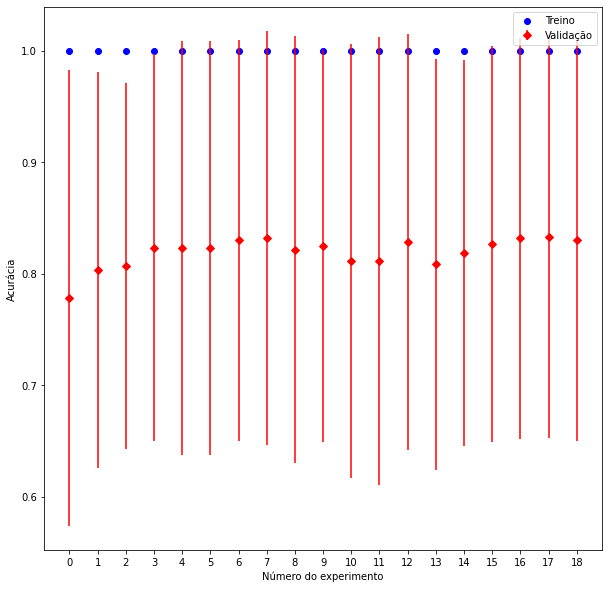

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
17,{'mlp__batch_size': 180},1.00,0.00,0.83,0.18


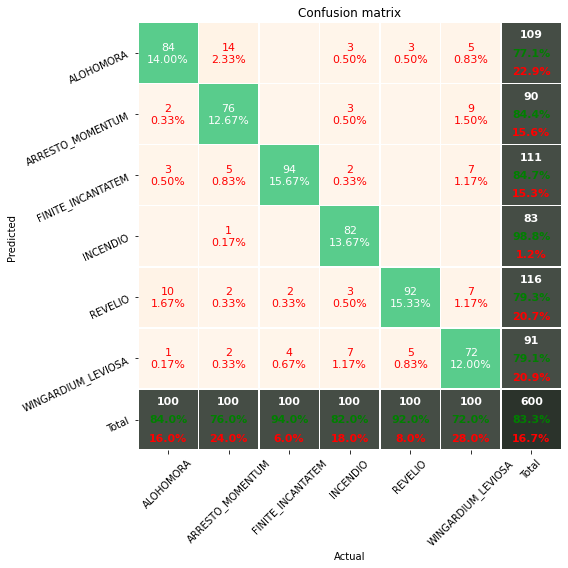

Pipeline(steps=[('mlp',
                 MLPClassifier(batch_size=180, hidden_layer_sizes=(100, 10),
                               learning_rate_init=0.0005, max_iter=100000,
                               random_state=0))])

In [10]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, 
                          hidden_layer_sizes=(100, 10), learning_rate_init=0.0005))
])

parameters = {'mlp__batch_size': np.arange(10, 200, 10)}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Sem diferenças no batch-size, vamos usar o padrao do scikit-learn que é 200

### Testando Scalers

train_scores:     ['1.00', '1.00', '1.00', '1.00', '1.00'] 
mean_train_score: 1.00
std_train_score:  0.00


test_scores:      ['0.95', '0.42', '0.82', '0.94', '0.87']
mean_test_score:  0.80
std_test_score:   0.20


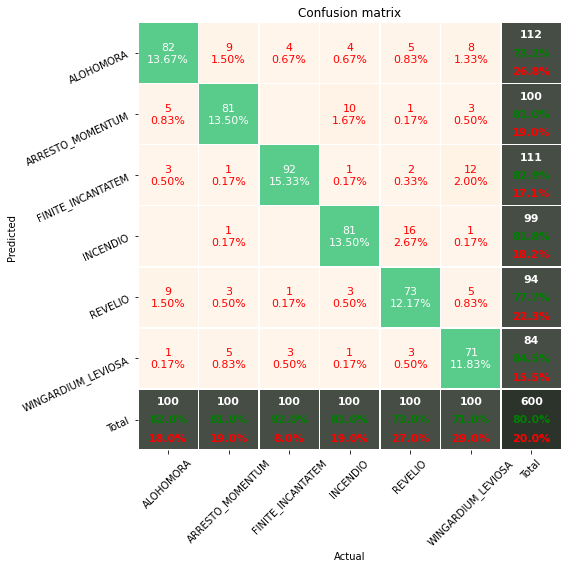

In [14]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, 
                          hidden_layer_sizes=(100, 10), learning_rate_init=0.0005))
])

scikit_train_validate(pipe, X_processed, database_train.y, database_train.cv_author)

train_scores:     ['1.00', '1.00', '1.00', '1.00', '1.00'] 
mean_train_score: 1.00
std_train_score:  0.00


test_scores:      ['0.94', '0.42', '0.86', '0.88', '0.82']
mean_test_score:  0.78
std_test_score:   0.18


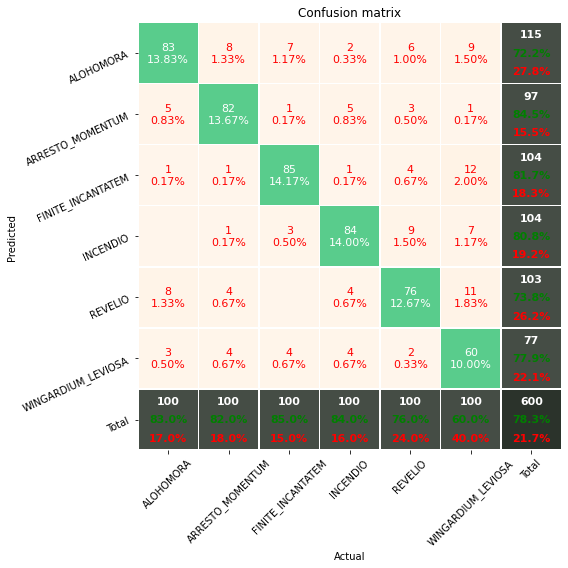

In [15]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, 
                          hidden_layer_sizes=(100, 10), learning_rate_init=0.0005))
])

scikit_train_validate(pipe, X_processed, database_train.y, database_train.cv_author)

Vimos que os métodos de escala não trouxeram benefícios, isso é entendível já que o Acelerometro e Giroscopio estão praticamente na mesma escala, como pode ser visto nesse exemplo:

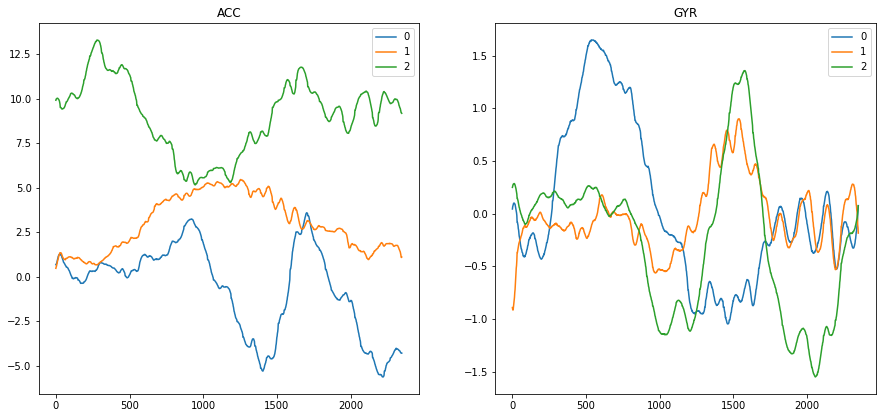

In [14]:
plot_all_readings(database_train.datalist[0].readings, table_format=(0, 2))

### Testando regularização l2

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:   15.0s remaining:    7.0s
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed:   19.1s remaining:    4.8s
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed:   20.5s remaining:    1.8s
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:   21.3s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__alpha': 1e-05},1.00,0.00,0.82,0.18
1,{'mlp__alpha': 0.0001},1.00,0.00,0.84,0.18
2,{'mlp__alpha': 0.01},1.00,0.00,0.83,0.19
3,{'mlp__alpha': 0.1},1.00,0.00,0.80,0.18
4,{'mlp__alpha': 1},1.00,0.00,0.76,0.18


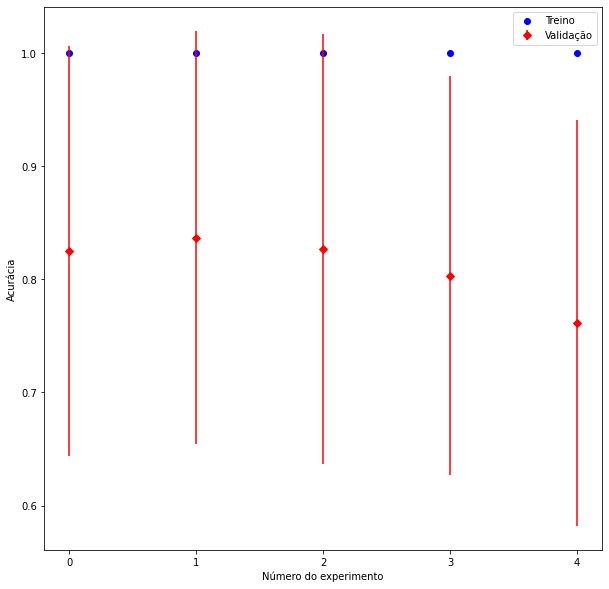

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
1,{'mlp__alpha': 0.0001},1.00,0.00,0.84,0.18


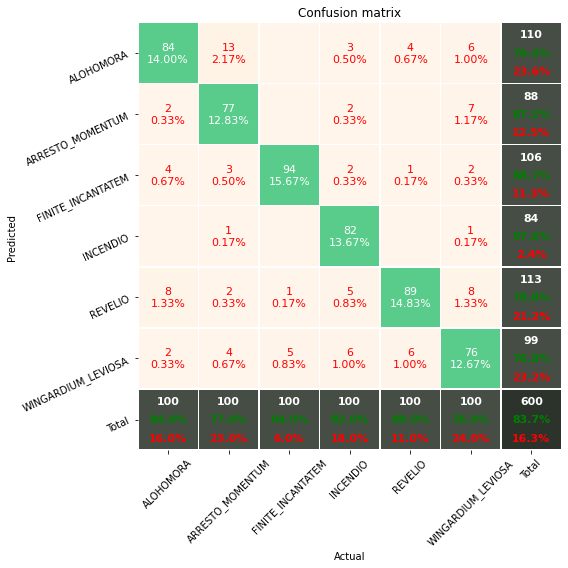

Pipeline(steps=[('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 10),
                               learning_rate_init=0.0005, max_iter=100000,
                               random_state=0))])

In [20]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, 
                          hidden_layer_sizes=(100, 10), learning_rate_init=0.0005))
])

parameters = {'mlp__alpha': [0.00001, 0.0001, 0.01, 0.1, 1]}

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vimos que agora um alpha de 0.0001 melhorou suavemente o modelo na validação e deixou com menos overfit

### Early-stop

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   10.2s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   35.7s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   57.2s
[Parallel(n_jobs=6)]: Done  45 out of  50 | elapsed:  1.3min remaining:    8.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.5min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'mlp__n_iter_no_change': 100},0.98,0.01,0.74,0.17
1,{'mlp__n_iter_no_change': 300},0.99,0.01,0.74,0.16
2,{'mlp__n_iter_no_change': 500},0.99,0.00,0.80,0.17
3,{'mlp__n_iter_no_change': 700},0.99,0.00,0.80,0.17
4,{'mlp__n_iter_no_change': 900},1.00,0.00,0.79,0.19
5,{'mlp__n_iter_no_change': 1100},1.00,0.00,0.79,0.19
6,{'mlp__n_iter_no_change': 1300},1.00,0.00,0.79,0.19
7,{'mlp__n_iter_no_change': 1500},1.00,0.00,0.79,0.19
8,{'mlp__n_iter_no_change': 1700},1.00,0.00,0.79,0.19
9,{'mlp__n_iter_no_change': 1900},1.00,0.00,0.79,0.19


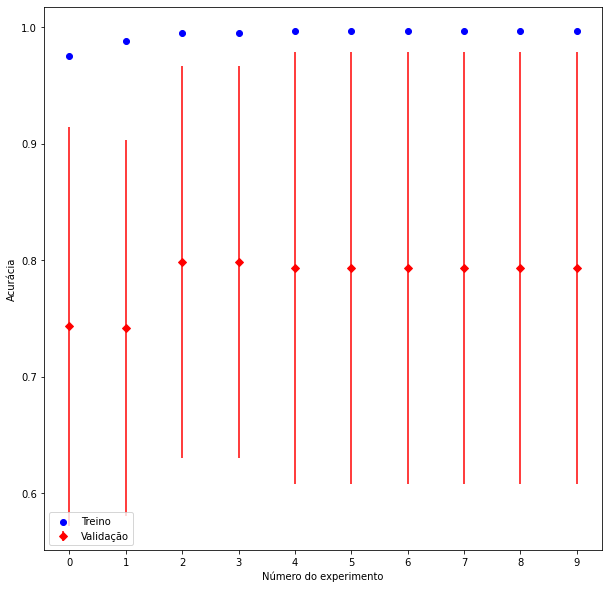

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
2,{'mlp__n_iter_no_change': 500},0.99,0.00,0.80,0.17


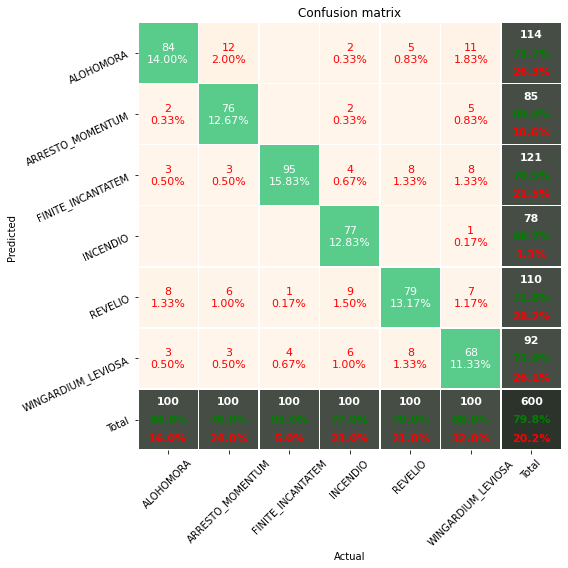

Pipeline(steps=[('mlp',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(100, 10),
                               learning_rate_init=0.0005, max_iter=100000,
                               n_iter_no_change=500, random_state=0))])

In [24]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, alpha=0.0001,
                          hidden_layer_sizes=(100, 10), learning_rate_init=0.0005, early_stopping=True))
])

parameters = {'mlp__n_iter_no_change': np.arange(100, 2000, 200)}

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vimos que o método early_stopping não trouxe beneficios ao modelo.

### Numero de neuronios

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:    5.0s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:    7.3s remaining:    0.8s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    7.9s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__hidden_layer_sizes': (10,)}",1.00,0.00,0.76,0.18
1,"{'mlp__hidden_layer_sizes': (100,)}",1.00,0.00,0.74,0.17
2,"{'mlp__hidden_layer_sizes': (500,)}",1.00,0.00,0.76,0.15
3,"{'mlp__hidden_layer_sizes': (1000,)}",1.00,0.00,0.76,0.16


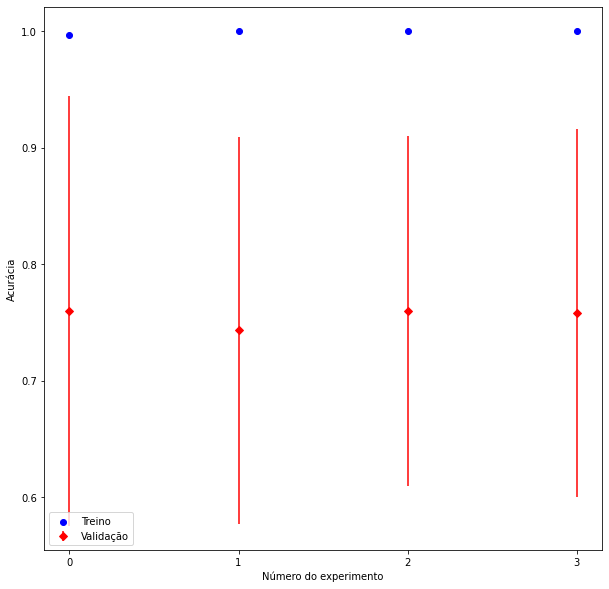

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__hidden_layer_sizes': (10,)}",1.00,0.00,0.76,0.18


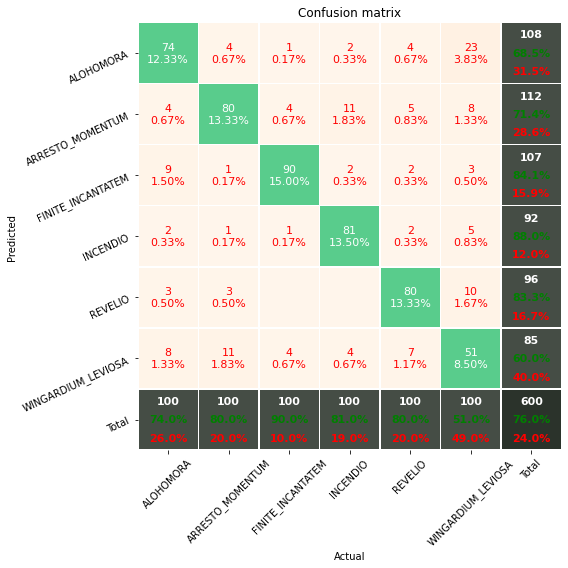

Pipeline(steps=[('mlp',
                 MLPClassifier(hidden_layer_sizes=(10,),
                               learning_rate_init=0.0005, max_iter=100000,
                               random_state=0))])

In [28]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, alpha=0.0001, learning_rate_init=0.0005))
])
 
parameters = {'mlp__hidden_layer_sizes': [(10,), (100,), (500,), (1000,)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   13.0s
[Parallel(n_jobs=6)]: Done  34 out of  40 | elapsed:   14.3s remaining:    2.5s
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   16.3s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'mlp__hidden_layer_sizes': (50, 5)}",0.97,0.02,0.66,0.20
1,"{'mlp__hidden_layer_sizes': (50, 10)}",0.99,0.01,0.69,0.22
2,"{'mlp__hidden_layer_sizes': (100, 5)}",1.00,0.00,0.72,0.19
3,"{'mlp__hidden_layer_sizes': (100, 10)}",1.00,0.00,0.84,0.18
4,"{'mlp__hidden_layer_sizes': (100, 20)}",1.00,0.00,0.77,0.17
5,"{'mlp__hidden_layer_sizes': (100, 20, 10)}",1.00,0.00,0.70,0.17
6,"{'mlp__hidden_layer_sizes': (200, 20, 10)}",1.00,0.00,0.72,0.19
7,"{'mlp__hidden_layer_sizes': (500, 50, 10)}",1.00,0.00,0.72,0.21


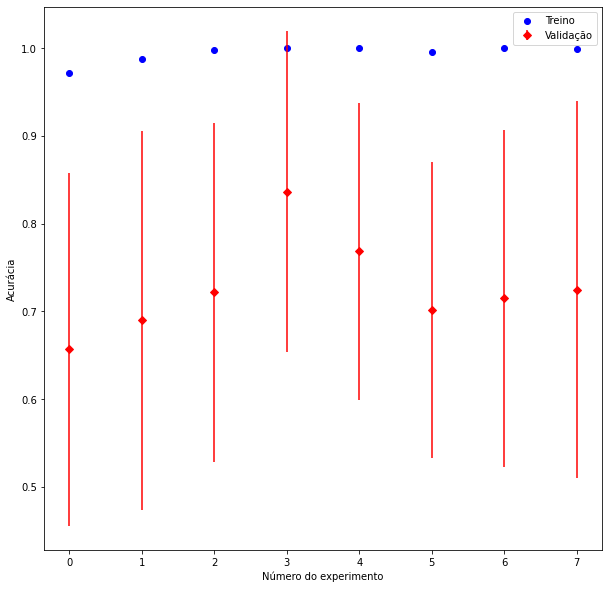

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,"{'mlp__hidden_layer_sizes': (100, 10)}",1.00,0.00,0.84,0.18


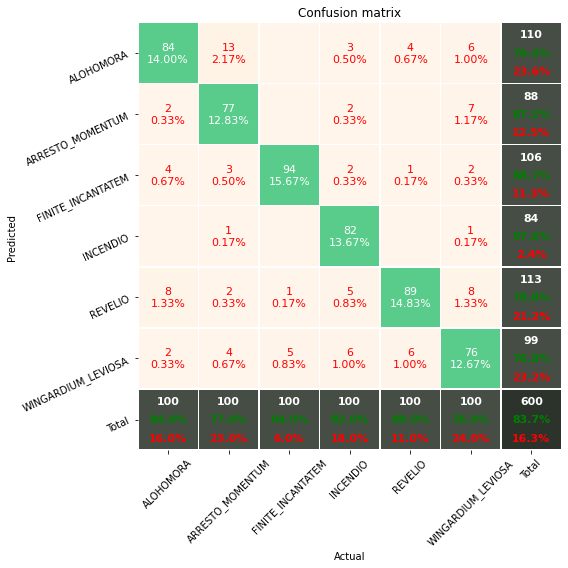

Pipeline(steps=[('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 10),
                               learning_rate_init=0.0005, max_iter=100000,
                               random_state=0))])

In [30]:
pipe = Pipeline([
    ('mlp', MLPClassifier(random_state=0, max_iter=100000, alpha=0.0001, learning_rate_init=0.0005))
])
 
parameters = {'mlp__hidden_layer_sizes': [(50, 5), (50, 10), (100, 5), (100, 10), (100, 20), (100, 20, 10), (200, 20, 10), (500, 50, 10)]}
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Aparentemete as redes neurais ficaram piores com o aumento do numero de camadas. O numero *'mlp__hidden_layer_sizes': (100, 10)* deixou a rede neural melhor para o problema. Vamos salvar esse modelo e utilizá-lo pra previsões:

In [43]:
import pickle

pipe = Pipeline([
    ('interpolate', InterpolateRawData(num_samples=40)),
    ('mlp', MLPClassifier(random_state=0, hidden_layer_sizes=(100, 10),
                          max_iter=100000, alpha=0.0001, learning_rate_init=0.0005))
])

pipe.fit(database_train.X, database_train.y)
 
with open('models/best_fully_connected.pkl', 'wb') as file:
    pickle.dump(pipe, file)